In [10]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN



    def forward(self, x, start_token, end_token): # sentence
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x






class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x.clone()
        x = self.attention(x, mask=self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x.clone()
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x

class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

class Encoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask, start_token, end_token):
        x = self.sentence_embedding(x, start_token, end_token)
        x = self.layers(x, self_attention_mask)
        return x


class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size() # in practice, this is the same for both languages...so we can technically combine with normal attention
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)

        values, attention = scaled_dot_product(q, k, v, mask) # We don't need the mask for cross attention, removing in outer function!
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y


class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

class Decoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask, start_token, end_token):
        y = self.sentence_embedding(y, start_token, end_token)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y


class Transformer(nn.Module):
    def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers,
                max_sequence_length,
                kn_vocab_size,
                english_to_index,
                kannada_to_index,
                START_TOKEN,
                END_TOKEN,
                PADDING_TOKEN
                ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, english_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, kannada_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.linear = nn.Linear(d_model, kn_vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self,
                x,
                y,
                encoder_self_attention_mask=None,
                decoder_self_attention_mask=None,
                decoder_cross_attention_mask=None,
                enc_start_token=False,
                enc_end_token=False,
                dec_start_token=False, # We should make this true
                dec_end_token=False): # x, y are batch of sentences
        x = self.encoder(x, encoder_self_attention_mask, start_token=enc_start_token, end_token=enc_end_token)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask, start_token=dec_start_token, end_token=dec_end_token)
        out = self.linear(out)
        return out

In [11]:
import pandas as pd

# Read the Excel file
df = pd.read_excel('/content/sample_data/datas.xlsx', sheet_name='Sheet1')

# Access all the values of the specified column
standard_column = df['Standard Bangla Language'].tolist()
noakhali_column = df['Noakhali Language'].tolist()
# Print the values of the column
print(len(standard_column))
print((noakhali_column[:10]))


141
['মুই বাসা যামু না', 'হেতে মিছা অতা কয়', 'তুই কোনান তুন আইছ ?', 'হেতে হানিত্তে হড়ি গেছে', 'হেতে বাপের বড় হোলা', 'তুই খাই হুতিজা', 'তুই কি হাগল অই গেছত্তি ?', 'হেতে আরে হোন কইর্ছিলো', 'হিছা মারি তোর কোয়ালে', 'তুই এনে করি কান্দরি কিল্লাই?']


In [12]:
N_sentences = noakhali_column.copy()
S_sentences = standard_column.copy()

In [13]:
START_TOKEN = '<sosa>'
PADDING_TOKEN = '<pada>'
END_TOKEN = '<eosa>'

N_vocabulary = [START_TOKEN, 'আছেন','কি?', 'ন', 'কি', 'আই', 'তুই', 'আন্নে', 'আর', 'না?', 'এহন', 'হন', '', 'আরে', 'ইতে', 'এক্কানা', 'না', 'লগে', 'ইতের', '?', 'অই', 'আছে', 'এই', 'এড়ে', 'কিছু', 'খাই', 'গরি', 'গো', 'তুন', 'তুর', 'তো', 'দিন', 'দেই', 'দেহা', 'মনে', 'যাইয়ুম', 'হাজ', 'হেতে', 'অনেক', 'আইছি', 'আইটতে', 'আচন', 'আজিএ', 'আন্নের', 'আন্নেরা', 'ইবে', 'ইয়েন', 'উন্নিশে', 'এস', 'করি', 'কলেজত', 'গরম', 'গুস্সা', 'গেছে', 'জাগা', 'টিয়া', 'ঢাকাত', 'তোরে', 'দি', 'নি', 'পানি', 'বালা', 'ভালা', 'মুই', 'যাইলি', 'লাগের', 'লার', 'হাগল', 'হাচ', 'হুতিজা', 'অ?', 'অইছে', 'অইবু', 'অইল', 'অতা', 'অন্নেরা', 'অফিসের', 'অবস্থা?', 'অয়', 'অয়ই', 'অয়ই', 'আঁত্তুন', 'আঁন্নে', 'আঁর', 'আংগো', 'আইও', 'আইছ', 'আইনতু', 'আইলি', 'আইসতান্ন', 'আইসসুম', 'আইস্সুম', 'আচিলাম', 'আছালাম', 'আছি', 'আছিলেন', 'আছে?', 'আছেনা?', 'আজি', 'আত্তে', 'আন্ডা', 'আন্নেগরে', 'আফা', 'আবার', 'আমার', 'আমি', 'আম্নেরে', 'আম্মা', 'আরতুন', 'আরার', 'আলাইছে', 'ই', 'ইয়ান', 'ইয়ানও', 'উট', 'উডি', 'এক', 'একটা', 'এক্কারি', 'এখখানা', 'এগিন', 'এত', 'এতকিছু', 'এতো', 'এদ্দিন', 'এর', 'ওডা', 'ওয়াইরজ্জে', 'কইচ্ছেন?', 'কইছি', 'কইতাম', 'কতা', 'কম্প্লিট', 'করাই', 'করে', 'করেন', 'কাডাইছিলাম', 'কাম', 'কামাআআয়', 'কিঁয়া', 'কিল্লাই?', 'কিয়া', 'কে', 'কোন', 'কোনসম', 'কোনান', 'কোনান্দি', 'কোনো', 'কোবতে', 'কোয়ালে', 'ক্যান?', 'ক্লাস', 'কয়', 'খাইচেন্নি', 'খাইতে', 'খানা-দানা', 'খালি', 'গ', 'গম', 'গরজু', 'গরজুইন', 'গরতাইম', 'গরে', 'গরে?', 'গরের', 'গাড়ি', 'গেউস', 'গেছত্তি', 'গেল', 'গেলাস', 'গেলে', 'গ্যাছেনি', 'গ্যাস্টিক', 'গড়ি', 'ঘুম', 'ঘুমেত্তুন', 'চলি', 'চলেন', 'চা--রী', 'চাই', 'জব', 'জাপান', 'জামাই', 'জিনিসগান', 'টাইম', 'টাজ', 'টেঁয়া', 'ঠ্যাং', 'ডক', 'ডাকি', 'ডিমগা', 'ত', 'তাইলে', 'তারাতারি', 'তুঙ্গ', 'তুয়ই', 'তুয়ার', 'তেলেদি', 'তো', 'তোর', 'তোরা', 'তোয়ারার', 'তোঁয়ার', 'তোগোরে', 'তোর', 'তোয়াই', 'তোয়ার', 'দন', 'দিওন', 'দিছি', 'দিত', 'দিতেন?', 'দিব?', 'দিলে', 'দিলেন', 'দিয়েন্না', 'দুক', 'দে', 'দেছেন', 'দেরি', 'দেশে', 'দেশের', 'নগরে', 'নতুন', 'নবুঝি', 'নাই', 'নাট্যমি', 'নাম্বার', 'নিয়ে', 'নোয়াখালির', 'নোয়াখালী', 'নোয়াখাইল্যা', 'পছন্দ', 'পরতি', 'পরা', 'পরে', 'পরোদে?', 'পা', 'পাইত্তো', 'পাইবেন', 'পাইয়র', 'পাইয়ুস', 'ফাইত্তানো', 'ফুয়াদ', 'ব', 'বহুত', 'বাই', 'বাইজ্জে', 'বাইত', 'বাজার', 'বাড়িত', 'বাতরুমে', 'বাপের', 'বাষা', 'বাসা', 'বাসাত', 'বিএসি', 'বিষ', 'বুজির', 'বেশী', 'বেয়ুশ', 'ব্যাগ', 'ব্যাচ', 'বড়', 'ভাই', 'ভালোবাসা', 'ভাষা', 'ভাড়া', 'মাইজদিতে', 'মাইজদী', 'মাইত্তো', 'মাতাত', 'মারি', 'মিক্কে', 'মিছা', 'ম্যালা', 'যাইছ', 'যাইতে', 'যাইয়েন', 'যান', 'যাবি?', 'যামু', 'যায়বু', 'যায়তা', 'যে', 'যেন', 'রাগ', 'রানওয়ে', 'রিক্সাত', 'লই', 'লইগেলি', 'লগেদি', 'লাই', 'লাইগগুকা?', 'লাইগগোদে', 'লাগছে', 'লাগে', 'লিখছি', 'লোক', 'লয়', 'শতান', 'শরম', 'শার্ট', 'সমস্যা', 'সমস্যা?', 'সম্যাসা', 'সরকারী', 'সাবজেক্টের', 'সামান্য', 'সারি', 'সি', 'সৃতি', 'সোজা', 'স্কুলত', 'হইতারিবেন', 'হইদি', 'হইয়া', 'হইয়ুন', 'হডে', 'হতা', 'হদ্দুর', 'হয়ই', 'হরান', 'হরিষ্কার', 'হরে', 'হাঁসটা', 'হাইয়াগুন', 'হাচুরুন', 'হানি', 'হানিত্তে', 'হালাই', 'হালিয়ে', 'হিছা', 'হিয়ান', 'হুইরে', 'হেই', 'হেতির', 'হেরুম', 'হোলা', 'হোয়াদ', 'হড়ি', '৯৫', PADDING_TOKEN, END_TOKEN]

S_vocabulary = [START_TOKEN,'আছেন', 'কি?', 'কি','যাবি?', 'তোরা', 'না', 'আমি', 'আমার', 'তুমি', 'করে', 'সে', '', 'আপনি', 'অনেক', 'আমাকে', 'সাথে', 'এখন', 'কিছু', 'গেলে', 'এই', 'একটু', 'ওর', 'কথা', 'কাজ', 'কোন', 'থেকে', 'মনে', 'আছে', 'আজকে', 'আপনারা', 'কী', 'টাকা', 'তোমাদের', 'তোমার', 'দিন', 'দেখা', 'পানি', 'ভালো', 'যাব', 'রাগ', 'লাগছে', 'হয়ে', 'আছে?', 'আপনার', 'আমাদের', 'আসব', 'এটা', 'এত', 'এস', 'এসেছি', 'ওখানে', 'কলেজে', 'কেন', 'কেন?', 'কোনো', 'খেয়ে', 'গরম', 'জায়গাটা', 'তোর', 'তো', 'তোকে', 'দাও', 'পাঁচ', 'পড়ে', 'বমি', 'বলতে', 'বলে', 'বলেছে', 'বাড়ি', 'ব্যথা', 'ভাই', 'ভাল', 'ভাষা', 'সমস্যা', 'হাঁটতে', 'হয়েছে', '?', 'অফিসের', 'অবস্থা?', 'অভিভূত', 'আছি', 'আছেন?', 'আনতে', 'আপনাকে', 'আপনাদের', 'আপনাদেরকে', 'আপা', 'আবার', 'আমরা', 'আমারতো', 'আমিও', 'আম্মা', 'আসছিলাম', 'আসবো', 'আসলে', 'উঠ', 'উঠে', 'এক', 'একটা', 'একটুও', 'একদিন', 'একেবারে', 'এখনও', 'এখান', 'এখানে', 'এর', 'এসেছ?', 'কপালে', 'কবিতা', 'কম্প্লিট', 'করছে', 'করছেন', 'করতে', 'করব', 'করিয়ে', 'করে?', 'করেছ?', 'করেছে', 'করেছেন', 'করেছেন?', 'করেন', 'কাছে', 'কাটা', 'কাটাইছিলাম', 'কামায়', 'কালকে', 'কে', 'কোথা', 'কোথাও', 'কোথায়?', 'কোথায়', 'কোন', 'কোনসময়', 'ক্লাস', 'খাওয়া-দাওয়া', 'খুঁজে', 'খেতে', 'খেয়ে', 'গাড়ি', 'গিয়েছে', 'গেছস', 'গেছে', 'গেছে?', 'গেল', 'গ্যাস্টিক', 'গ্রামের', 'গ্লাস', 'ঘুম', 'ঘুমাচ্ছ', 'চলে', 'চলেন', 'চাকুরী', 'ছিলাম', 'ছিলেন', 'ছেলে', 'ছেড়ে', 'জন্য', 'জব', 'জাপান', 'জামাই', 'জিনিসটা', 'ঝাড়ু', 'ডাকি', 'ডিমটা', 'ঢাকা', 'ঢাকায়', 'তার', 'তাহলে', 'তাড়াতাড়ি', 'তো', 'তোমাদের', 'তোমার', 'তো!', 'তোর', 'দিই', 'দিতে?', 'দিবে?', 'দিবেন', 'দিলে', 'দিলেন', 'দিয়েছি', 'দিয়েন', 'দুর', 'দুস্ট', 'দেই,', 'দেখে', 'দেন', 'দেরি', 'দেশে', 'দেশের', 'নতুন', 'না?', 'নাই?', 'নাটক', 'নাম্বারটা', 'নিই', 'নিয়ে', 'নিয়ে', 'নেই', 'নোয়াখালির', 'নোয়াখালী', 'নোয়াখাইল্যা', 'নয়', 'পছ্ন্দ', 'পড়', 'পড়া', 'পরান', 'পরিষ্কার', 'পরেই', 'পা', 'পাঁচটা', 'পাওয়া', 'পাগল', 'পাগল?', 'পাচ্ছি', 'পানিতে', 'পার', 'পারছি', 'পারব', 'পারবেন', 'পুকুরে', 'পেঁপেগুলো', 'পেয়েছ?', 'পড়', 'পড়তে', 'পড়ো?', 'বন্ধু', 'বলছি', 'বলবেন', 'বলিও', 'বলেছি', 'বস', 'বাজার', 'বাজে', 'বাড়ি', 'বাথরুমে', 'বাবার', 'বাসাই', 'বাড়িতে', 'বিএসসি', 'বুঝি', 'বুঝিনা', 'বেশি', 'ব্যাগ', 'ব্যাচ', 'বড়', 'ভাজি', 'ভালোবাসতে', 'ভাড়া', 'মাইজদিতে', 'মাইজদীর', 'মাথায়', 'মারি', 'মিথ্যা', 'যান', 'যাবা', 'যাবে?', 'যাবেন', 'যাবো', 'যেওনা', 'রানওয়ে', 'রিক্সায়', 'লজ্জা', 'লাগে', 'লিখছি', 'লেগেছে', 'লোক', 'শার্টটা', 'শুয়ে', 'শুয়ে', 'সঙ্গে', 'সমস্যা?', 'সময়', 'সরকারি', 'সহজ', 'সাঁতার', 'সাবজেক্টের', 'সামান্য', 'সি', 'সেই', 'সেখানে', 'সেরকম', 'সেরে', 'সৌন্দর্য', 'স্কুলে', 'স্বাদ', 'স্মৃতি', 'হবে', 'হয়', 'হয়ে', 'হয়েছে', 'হয়েছে?', 'হয়', 'হয়েছিল', '৯৫', PADDING_TOKEN, END_TOKEN]

In [14]:
'should' in N_vocabulary

False

In [15]:
for sent in S_sentences:
        if 'should' in sent:
            print('sd')

In [16]:
len(S_vocabulary)

298

In [17]:
index_to_S = {k:v for k,v in enumerate(S_vocabulary)}
S_to_index = {v:k for k,v in enumerate(S_vocabulary)}
index_to_N = {k:v for k,v in enumerate(N_vocabulary)}
N_to_index = {v:k for k,v in enumerate(N_vocabulary)}


In [18]:
#S_to_index['আছেন']
N_to_index['আছেন']

1

In [19]:
N_sentences = [sentence.rstrip('\n') for sentence in N_sentences]
S_sentences = [sentence.rstrip('\n') for sentence in S_sentences]

In [20]:
print(N_sentences[:10])
print(S_sentences[:10])

['মুই বাসা যামু না', 'হেতে মিছা অতা কয়', 'তুই কোনান তুন আইছ ?', 'হেতে হানিত্তে হড়ি গেছে', 'হেতে বাপের বড় হোলা', 'তুই খাই হুতিজা', 'তুই কি হাগল অই গেছত্তি ?', 'হেতে আরে হোন কইর্ছিলো', 'হিছা মারি তোর কোয়ালে', 'তুই এনে করি কান্দরি কিল্লাই?']
['আমি বাড়ি যাব না', 'সে মিথ্যা কথা বলেছে', 'তুমি কোথা থেকে এসেছ?', 'সে পানিতে পড়ে গিয়েছে', 'সে বাবার বড় ছেলে', 'তুমি খেয়ে শুয়ে পড়', 'তুমি কি পাগল হয়ে গেলে ?', 'সে আমাকে ফোন করেছিল', 'তোমার কপালে ঝাড়ু মারি', 'তুমি এমন করে কাঁদছো কেন?']


In [21]:
max_sequence_length = 30

def is_valid_tokens(sentence, vocab):
    for token in sentence.split():
        if token not in vocab:
            return False
    return True

def is_valid_length(sentence, max_sequence_length):
    return len(sentence.split()) < (max_sequence_length - 1) # need to re-add the end token so leaving 1 space

valid_sentence_indicies = []
for index in range(len(S_sentences)):
    S_sentence, N_sentence = S_sentences[index], N_sentences[index]
    if is_valid_length(S_sentence, max_sequence_length) \
      and is_valid_length(N_sentence, max_sequence_length) \
      and is_valid_tokens(S_sentence, S_vocabulary):
        valid_sentence_indicies.append(index)

print(f"Number of sentences: {len(S_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of sentences: 141
Number of valid sentences: 100


In [22]:
S_sentences = [S_sentences[i] for i in valid_sentence_indicies]
N_sentences = [N_sentences[i] for i in valid_sentence_indicies]

In [23]:
print(N_sentences[:10])
print(S_sentences[:10])

['মুই বাসা যামু না', 'হেতে মিছা অতা কয়', 'তুই কোনান তুন আইছ ?', 'হেতে হানিত্তে হড়ি গেছে', 'হেতে বাপের বড় হোলা', 'তুই খাই হুতিজা', 'তুই কি হাগল অই গেছত্তি ?', 'হিছা মারি তোর কোয়ালে', 'বহুত শতান অই গেউস', 'তুয়ই এত দেরি গরি ঘুম যাইতে লাইগগুকা?']
['আমি বাড়ি যাব না', 'সে মিথ্যা কথা বলেছে', 'তুমি কোথা থেকে এসেছ?', 'সে পানিতে পড়ে গিয়েছে', 'সে বাবার বড় ছেলে', 'তুমি খেয়ে শুয়ে পড়', 'তুমি কি পাগল হয়ে গেলে ?', 'তোমার কপালে ঝাড়ু মারি', 'অনেক দুস্ট হয়ে গেছস', 'তুমি এত দেরি করে ঘুমাচ্ছ কেন?']


In [24]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, N_sentences, S_sentences):
        self.N_sentences = N_sentences
        self.S_sentences = S_sentences

    def __len__(self):
        return len(self.N_sentences)

    def __getitem__(self, idx):
        return self.N_sentences[idx], self.S_sentences[idx]

In [25]:
dataset = TextDataset(N_sentences, S_sentences)

In [26]:
len(dataset)

100

In [27]:
batch_size = 20
train_loader = DataLoader(dataset, batch_size=batch_size)
iterator = iter(train_loader)


In [28]:
for batch_num, batch in enumerate(iterator):
    print(len(batch[0]))
    if batch_num > 3:
        break

20
20
20
20
20


In [29]:
'''
def tokenize(sentence, language_to_index, start_token=True, end_token=True):
    sentence_word_indicies = [language_to_index[token] for token in sentence.split()]
    if start_token:
        sentence_word_indicies.insert(0, language_to_index[START_TOKEN])
    if end_token:
        sentence_word_indicies.append(language_to_index[END_TOKEN])
    for _ in range(len(sentence_word_indicies), max_sequence_length):
        sentence_word_indicies.append(language_to_index[PADDING_TOKEN])
    return torch.tensor(sentence_word_indicies)
'''

'\ndef tokenize(sentence, language_to_index, start_token=True, end_token=True):\n    sentence_word_indicies = [language_to_index[token] for token in sentence.split()]\n    if start_token:\n        sentence_word_indicies.insert(0, language_to_index[START_TOKEN])\n    if end_token:\n        sentence_word_indicies.append(language_to_index[END_TOKEN])\n    for _ in range(len(sentence_word_indicies), max_sequence_length):\n        sentence_word_indicies.append(language_to_index[PADDING_TOKEN])\n    return torch.tensor(sentence_word_indicies)\n'

In [30]:
''''import torch
max_sequence_length = 30
eng_tokenized, kn_tokenized = [], []
for sentence_num in range(batch_size):
    eng_sentence, kn_sentence = batch[0][sentence_num], batch[1][sentence_num]
    eng_tokenized.append( tokenize(eng_sentence, english_to_index, start_token=False, end_token=False) )
    kn_tokenized.append( tokenize(kn_sentence, kannada_to_index, start_token=True, end_token=True) )
eng_tokenized = torch.stack(eng_tokenized)
kn_tokenized = torch.stack(kn_tokenized)'''

"'import torch\nmax_sequence_length = 30\neng_tokenized, kn_tokenized = [], []\nfor sentence_num in range(batch_size):\n    eng_sentence, kn_sentence = batch[0][sentence_num], batch[1][sentence_num]\n    eng_tokenized.append( tokenize(eng_sentence, english_to_index, start_token=False, end_token=False) )\n    kn_tokenized.append( tokenize(kn_sentence, kannada_to_index, start_token=True, end_token=True) )\neng_tokenized = torch.stack(eng_tokenized)\nkn_tokenized = torch.stack(kn_tokenized)"

In [31]:
#eng_tokenized

In [33]:
s_vocab_size = len(S_vocabulary)
s_vocab_size

298

In [34]:
import torch

d_model = 512
batch_size = 100
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 5
max_sequence_length = 30
s_vocab_size = len(S_vocabulary)

transformer = Transformer(d_model,
                          ffn_hidden,
                          num_heads,
                          drop_prob,
                          num_layers,
                          max_sequence_length,
                          s_vocab_size,
                          N_to_index,
                          S_to_index,
                          START_TOKEN,
                          END_TOKEN,
                          PADDING_TOKEN)

In [35]:
transformer

Transformer(
  (encoder): Encoder(
    (sentence_embedding): SentenceEmbedding(
      (embedding): Embedding(344, 512)
      (position_encoder): PositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): SequentialEncoder(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (qkv_layer): Linear(in_features=512, out_features=1536, bias=True)
          (linear_layer): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNormalization()
        (dropout1): Dropout(p=0.1, inplace=False)
        (ffn): PositionwiseFeedForward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNormalization()
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (attention): MultiHeadA

In [36]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')  # Download required NLTK data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
def calculate_bleu_score(reference_sentences, candidate_sentences):
    bleu_scores = []
    for ref, cand in zip(reference_sentences, candidate_sentences):
        reference = [ref.split()]  # Tokenize the reference sentence
        candidate = cand.split()     # Tokenize the candidate sentence
        bleu = sentence_bleu(reference, candidate)
        bleu_scores.append(bleu)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu


In [38]:
from torch import nn

criterian = nn.CrossEntropyLoss(ignore_index=S_to_index[PADDING_TOKEN],
                                reduction='none')

# When computing the loss, we are ignoring cases when the label is the padding token
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [39]:
num_epochs = 500
epoch_list = [i+1 for i in range(num_epochs)]
avg_bleu_all_epoch = []

In [40]:
transformer.train()
transformer.to(device)
total_loss = 0
num_epochs = 500
loss_in_epoches = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    avg_bleu_per_epoch = []
    train_loss_per_batch = []
    for batch_num, batch in enumerate(iterator):
        transformer.train()
        n_batch, s_batch = batch

        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(n_batch, s_batch)
        optim.zero_grad()
        s_predictions = transformer(n_batch,
                                     s_batch,
                                     encoder_self_attention_mask.to(device),
                                     decoder_self_attention_mask.to(device),
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=True)
        labels = transformer.decoder.sentence_embedding.batch_tokenize(s_batch, start_token=False, end_token=True)
        loss = criterian(
            s_predictions.view(-1, s_vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == S_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()

        train_loss_per_batch.append(loss.item())
        if batch_num % 10 <5:
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"nlish: {n_batch[0]}")
            print(f"S Translation: {s_batch[0]}")
            pre_sentences = []
            for i in range(20):
              s_sentence_predicted = torch.argmax(s_predictions[i], axis=1)
              predicted_sentence = ""
              for idx in s_sentence_predicted:
                if idx == S_to_index[END_TOKEN]:
                  break
                predicted_sentence += index_to_S[idx.item()] + " "
              #print(f"S Prediction: {predicted_sentence}")
              pre_sentences.append(predicted_sentence)

              #print(f"S Label: {s_batch[i]}")
              #print(f"nlish Label: {n_batch[i]}")
            print(s_batch)
            print(pre_sentences)
            avg_bleu_score = calculate_bleu_score(list(s_batch), pre_sentences)
            print(f'Average BLEU Score: {avg_bleu_score:.4f}')
            avg_bleu_per_epoch.append(avg_bleu_score)






            transformer.eval()
            s_sentence = (" ",)
            n_sentence = ("মুই বাসা যামু না",)
            for word_counter in range(max_sequence_length):
                encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(n_sentence, s_sentence)
                predictions = transformer(n_sentence,
                                          s_sentence,
                                          encoder_self_attention_mask.to(device),
                                          decoder_self_attention_mask.to(device),
                                          decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=True,
                                          dec_end_token=False)
                next_token_prob_distribution = predictions[0][word_counter] # not actual probs
                next_token_index = torch.argmax(next_token_prob_distribution).item()
                next_token = index_to_S[next_token_index]
                s_sentence = (s_sentence[0] + ' '+ next_token, )
                if next_token == END_TOKEN:
                  break

            print(f"Evaluation translation ( ) : {s_sentence}")

            print("-------------------------------------------")
    loss_in_epoches.append(sum(train_loss_per_batch)/len(train_loss_per_batch))
    avg_bleu_all_epoch.append(sum(avg_bleu_per_epoch)/5)


Epoch 0
Iteration 0 : 6.1032257080078125
nlish: মুই বাসা যামু না
S Translation: আমি বাড়ি যাব না
('আমি বাড়ি যাব না', 'সে মিথ্যা কথা বলেছে', 'তুমি কোথা থেকে এসেছ?', 'সে পানিতে পড়ে গিয়েছে', 'সে বাবার বড় ছেলে', 'তুমি খেয়ে শুয়ে পড়', 'তুমি কি পাগল হয়ে গেলে ?', 'তোমার কপালে ঝাড়ু মারি', 'অনেক দুস্ট হয়ে গেছস', 'তুমি এত দেরি করে ঘুমাচ্ছ কেন?', 'তুমি কি ব্যথা পেয়েছ?', 'তুমি কোন স্কুলে পড়ো?', 'তুমি ওখানে যেওনা', 'তোমার ওখানে কোন কাজ নেই', 'তুমি সেখানে গেলে আমাদের সমস্যা হবে', 'তুমি কি রাগ করেছ?', 'তুমি খেয়ে শুয়ে পড়', 'আমি এখানে এসেছি অনেক দিন হয়েছে', 'আপনারা আমাদের দেশে যাবেন', 'কি স্মৃতি মনে করিয়ে দিলেন')
['বাসাই দিতে? খেয়ে বাসাই বাসাই তাড়াতাড়ি বাসাই তাড়াতাড়ি দিতে? খেয়ে বাসাই বমি বাসাই বাসাই কোনো দিতে? বাসাই বাবার বাবার বাসাই বাসাই বাসাই বাসাই বাসাই বাসাই তাড়াতাড়ি বাবার বাবার বাসাই তাড়াতাড়ি ', 'বাসাই দিতে? বাসাই বাসাই বাসাই দিতে? বাসাই বাসাই বাসাই বাসাই বাসাই বাসাই বাসাই বাসাই বাসাই নাম্বারটা বাবার বাসাই বাসাই নাম্বারটা বাসাই বাসাই খেয়ে বাসাই বাসাই বাসাই বাসাই বাসাই নাম্বারটা খেয়ে ', 'গ্য

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Streaming output truncated to the last 5000 lines.
nlish: মুই বাসা যামু না
S Translation: আমি বাড়ি যাব না
('আমি বাড়ি যাব না', 'সে মিথ্যা কথা বলেছে', 'তুমি কোথা থেকে এসেছ?', 'সে পানিতে পড়ে গিয়েছে', 'সে বাবার বড় ছেলে', 'তুমি খেয়ে শুয়ে পড়', 'তুমি কি পাগল হয়ে গেলে ?', 'তোমার কপালে ঝাড়ু মারি', 'অনেক দুস্ট হয়ে গেছস', 'তুমি এত দেরি করে ঘুমাচ্ছ কেন?', 'তুমি কি ব্যথা পেয়েছ?', 'তুমি কোন স্কুলে পড়ো?', 'তুমি ওখানে যেওনা', 'তোমার ওখানে কোন কাজ নেই', 'তুমি সেখানে গেলে আমাদের সমস্যা হবে', 'তুমি কি রাগ করেছ?', 'তুমি খেয়ে শুয়ে পড়', 'আমি এখানে এসেছি অনেক দিন হয়েছে', 'আপনারা আমাদের দেশে যাবেন', 'কি স্মৃতি মনে করিয়ে দিলেন')
['আমি বাড়ি যাব না ', 'সে মিথ্যা কথা বলেছে ', 'তুমি কি থেকে এসেছ? ', 'সে পানিতে পড়ে গিয়েছে ', 'সে বাবার বড় ছেলে ', 'তুমি খেয়ে শুয়ে পড় ', 'তুমি কি পাগল হয়ে গেলে ? ', 'তোমার কপালে ঝাড়ু মারি ', 'অনেক দুস্ট হয়ে গেছস ', 'তুমি এত দেরি করে ঘুমাচ্ছ কেন? ', 'তুমি কি ব্যথা পেয়েছ? ', 'তুমি কোন স্কুলে পড়ো? ', 'তুমি ওখানে যেওনা ', 'এটা ওখানে কোন কাজ নেই ', 'মাথায় সেখানে গেলে আমাদের সমস্য

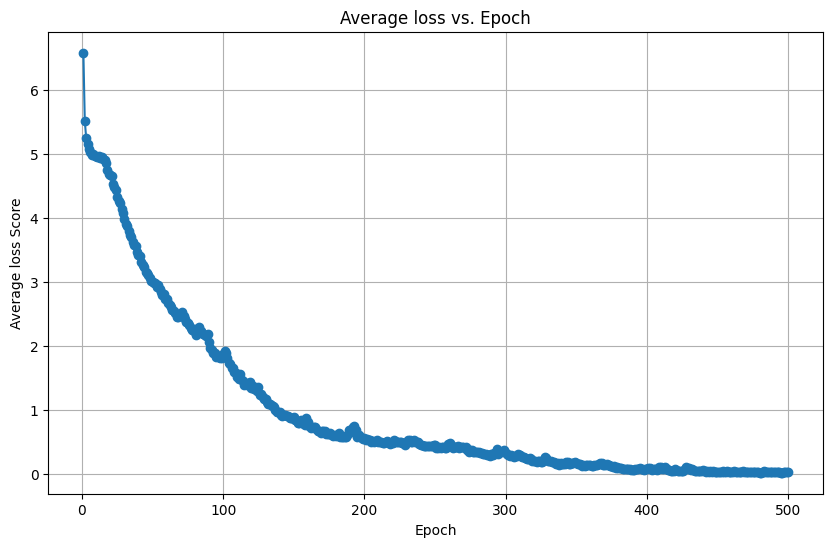

In [41]:
import matplotlib.pyplot as plt


# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, loss_in_epoches, marker='o')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Average loss Score')
plt.title('Average loss vs. Epoch')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

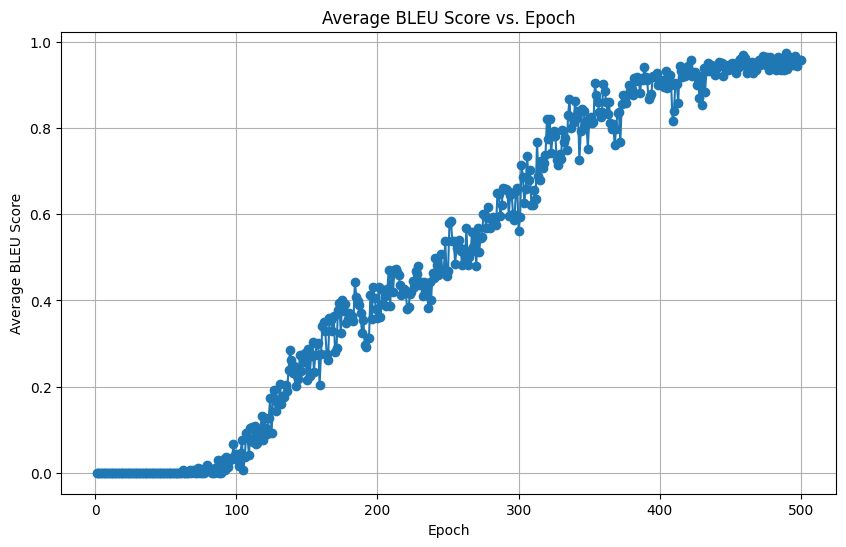

In [42]:
import matplotlib.pyplot as plt

# Example data: average BLEU score vs. epoch

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, avg_bleu_all_epoch, marker='o')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Average BLEU Score')
plt.title('Average BLEU Score vs. Epoch')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [43]:
transformer.eval()
s_sentence_t = ["","", "", "","", "","","","","",""]
n_sentence_t = ["তুই কোনান তুন আইছ ?","মুই বাসা যামু না",'হেতে মিছা অতা কয়', 'তুই কোনান তুন আইছ ?', 'হেতে হানিত্তে হড়ি গেছে', 'হেতে বাপের বড় হোলা', 'তুই খাই হুতিজা', 'তুই কি হাগল অই গেছত্তি ?', 'হিছা মারি তোর কোয়ালে', 'বহুত শতান অই গেউস', "তুয়ই এত দেরি গরি ঘুম যাইতে লাইগগুকা?"]

for i in range(11):
  s_sentence = (s_sentence_t[i],)
  n_sentence = (n_sentence_t[i],)
  for word_counter in range(max_sequence_length):
    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(n_sentence, s_sentence)
    predictions = transformer(n_sentence,
                            s_sentence,
                            encoder_self_attention_mask.to(device),
                            decoder_self_attention_mask.to(device),
                            decoder_cross_attention_mask.to(device),
                            enc_start_token=False,
                            enc_end_token=False,
                            dec_start_token=True,
                            dec_end_token=False)
    next_token_prob_distribution = predictions[0][word_counter] # not actual probs
    next_token_index = torch.argmax(next_token_prob_distribution).item()
    next_token = index_to_S[next_token_index]
    s_sentence = (s_sentence[0] + ' '+ next_token, )
    if next_token == END_TOKEN:
      break
  print(f"Noakhali Sentence ( ) : {n_sentence}")
  print(f"Evaluation translation ( ) : {s_sentence}")
  print("-------------------------------------------")



Noakhali Sentence ( ) : ('তুই কোনান তুন আইছ ?',)
Evaluation translation ( ) : (' তুমি কোথা থেকে এসেছ? <eosa>',)
-------------------------------------------
Noakhali Sentence ( ) : ('মুই বাসা যামু না',)
Evaluation translation ( ) : (' আমি বাড়ি যাব না <eosa>',)
-------------------------------------------
Noakhali Sentence ( ) : ('হেতে মিছা অতা কয়',)
Evaluation translation ( ) : (' সে মিথ্যা কথা বলেছে <eosa>',)
-------------------------------------------
Noakhali Sentence ( ) : ('তুই কোনান তুন আইছ ?',)
Evaluation translation ( ) : (' তুমি কোথা থেকে এসেছ? <eosa>',)
-------------------------------------------
Noakhali Sentence ( ) : ('হেতে হানিত্তে হড়ি গেছে',)
Evaluation translation ( ) : (' সে পানিতে পড়ে গিয়েছে <eosa>',)
-------------------------------------------
Noakhali Sentence ( ) : ('হেতে বাপের বড় হোলা',)
Evaluation translation ( ) : (' সে বাবার বড় ছেলে <eosa>',)
-------------------------------------------
Noakhali Sentence ( ) : ('তুই খাই হুতিজা',)
Evaluation translation ( ) : (' তু